# Entregable 2

In [1]:
# Imports
import zipfile
import csv
from io import TextIOWrapper
from datetime import datetime
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# White background for figures in notebook
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

## Funciones

In [2]:
# [numtickets] two dimensional list (keys: week-day, month - value: total ticket count)
numtickets = []

In [3]:
# [datescards] two dimensional list (keys: card_id - value: list of dates used)
datescards = []

In [4]:
# [deltas] list of deltas lower than max_delta
deltas = []
# list of cards with list of deltas lower than max_delta afterwards
carddeltas = []

In [5]:
# running this function can take 3 minutes or more
def load_datescards():
    # read datescards from csv
    print('loading datecards csv...')
    with open("processed-data/datescards.csv", 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        datescards = list(csv_reader)

    # convert datetime format
    print('converting format...')
    for d in range(len(datescards)):
        datescards[d] = [datescards[d][0]] + [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in datescards[d][1:]]

    # sort cards by len of list
    print('sorting...')
    datescards.sort(key=len, reverse=True)
    print('done!')

In [6]:
# running this function can take 3 minutes or more
def load_deltas():
    # read deltas from csv
    print('loading deltas from csv...')
    with open("processed-data/deltas.csv", 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        deltas = list(csv_reader)

    # map to int
    deltas = [int(num) for num in deltas]

    # read carddeltas from csv
    print('loading carddeltas from csv...')
    with open("processed-data/carddeltas.csv", 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        carddeltas = list(csv_reader)

    # map to int
    carddeltas = [[int(num) for num in sub] for sub in carddeltas[1:]]

## Pre-procesamiento
Los siguientes script acceden al dataset provisto, el cual debe estar en su forma original en la carpeta ./dataset.
Para cada zip file (correspondiente a cada mes), se parsean las siguientes variables: fecha, tarjeta, corredor, linea, sentido. Luego, cada script extrae un csv con un sub-set de datos adecuados para análisis específicos.

**Cada uno de los scripts de esta sección puede tomar hasta 10 horas dependiendo del poder de cómputo**

### Boletos Acumulados

* `numtickets.csv` Este csv guarda los totalizadores de boletos por dia de la semana y mes del año segun siguiente estructura:
`|'month'|'acc-month'|'acc-sun'|'acc-monday'|'acc-tue'|'acc-wed'|'acc-thu'|'acc-fri'|'acc-sat'`
donde `acc` refiere al totalizador y donde las columnas representan los dias de la semana y las filas los meses del años.

In [ ]:
# this script can take 30 (!) minutes or more

# [numtickets] two dimensional output list (keys: week-day, month - value: total ticket count)
numtickets = []

# iterate by month 1-12
numtickets.append(['month','acc-month','acc-sun','acc-mon','acc-tue','acc-wed','acc-thu','acc-fri','acc-sat'])
for i in range(1, 13):

    # get list of csv file in zip for this month
    print('processing month', i)
    try:
        zip_file = zipfile.ZipFile('dataset/boletos_2019-{:02d}.zip'.format(i), 'r')
        csv_list = zip_file.infolist()
    except:
        continue

    # [numtickets] add row for this month in output list
    numtickets.append([i,0,0,0,0,0,0,0,0])

    # iterate for each day in month
    for csv_file in csv_list:

        print('processing', csv_file.filename)
        file = zip_file.open(csv_file.filename, 'r')
        csv_reader = csv.reader(TextIOWrapper(file, 'latin-1'), delimiter=';')

        # iterate for each ticket entry
        for r, row in enumerate(csv_reader):
            if r == 0:
                continue

            # get all variables from row
            fecha = datetime.strptime(row[0], '%d/%m/%Y %I:%M:%S %p')
            fecha_apertura = datetime.strptime(row[1], '%d/%m/%Y %I:%M:%S %p')
            tarjeta = int(row[2])
            corredor = row[3]
            linea = row[4]
            sentido = row[5]
            
            # [numtickets] accumulate numticket for this entry
            numtickets[-1][int(fecha.strftime('%w'))+2] += 1
        
        # accumulate per month
        numtickets[-1][1] = np.sum(numtickets[-1][2:])

# [numtickets] save output list as csv
with open('processed-data/numtickets.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(numtickets)

### Tarjetas por Fechas

* `datescards.csv` Este csv cuenta con una fila por cada tarjeta en la que se listan las fechas en las cuales la misma fue utilizada con la siguiente estructura: `|'card-id'|'date-1'|'date-2'|'date-3'|...` donde `card-id` es le número de la tarjeta continuada con a lista de `date-N` en las cuales la misma fue usada.

In [ ]:
# this script can take 600 (!) minutes or more

# [datescards] two dimensional output list (key: card number - value: list of dates used)
datescards = []

# Auxiliary array to keep track of card index in datescards
cards = []

# iterate by month 1-12
for i in range(1, 13):

    # get list of csv file in zip for this month
    print('processing month', i)
    try:
        zip_file = zipfile.ZipFile('dataset/boletos_2019-{:02d}.zip'.format(i), 'r')
        csv_list = zip_file.infolist()
    except:
        continue

    # iterate for each day in month
    for csv_file in csv_list:

        print('processing', csv_file.filename)
        file = zip_file.open(csv_file.filename, 'r')
        csv_reader = csv.reader(TextIOWrapper(file, 'latin-1'), delimiter=';')

        # iterate for each ticket entry
        for r, row in enumerate(csv_reader):
            if r == 0:
                continue

            # get all variables from row
            fecha = datetime.strptime(row[0], '%d/%m/%Y %I:%M:%S %p')
            fecha_apertura = datetime.strptime(row[1], '%d/%m/%Y %I:%M:%S %p')
            tarjeta = int(row[2])
            corredor = row[3]
            linea = row[4]
            sentido = row[5]
            
            # [datescards] accumualte date in datescards for this card
            if tarjeta in cards:
                index = cards.index(tarjeta)
                datescards[index].append(fecha)
            else:
                datescards.append([tarjeta, fecha])
                cards.append(tarjeta)

# [datescards] save output list as csv
with open('processed-data/datescards.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(datescards)

### Delta Tiempo entre Tarjetas

* `deltas.csv` Este csv es simplementa una lista de deltas de tiempos entre los cuales una misma tarjeta fue utilizada siempre que dicho tiempo sea menor a `60` segundos. Esta lista sirve para medir la cantidad de usos compartidos de las tarjetas.
* `carddeltas.csv` Este csv cuenta con una fila por cada tarjeta en la que se listan los delta de tiempo entre el uso de la misma tarjeta menor a `60` segundos con la siguiente estructura: `|'card-id'|'delta-1'|'delta-2'|'delta-3'|...` donde `card-id` es le número de la tarjeta continuada con a lista de `delta-N` con los intervalos de uso.

In [14]:
# this script can take 60 minutes or more

# load datecards if not defined/loaded yet
try:
    datescards
except NameError:
    print('datescards no defined...')
    datescards = []
    load_datescards()
else:
    print('datescards defined...')
    if len(datescards) == 0:
        print('datescards empty...')
        load_datescards()
    print('datescards loaded...')

# maximum delta between cards in seconds
max_delta = 60
# list of deltas lower than max_delta
deltas = []
# list of cards with list of deltas afterwards
carddeltas = []
cards = []

# load deltas
print('populating deltas and carddetlas...')
for d1 in range(len(datescards)):
    for d2 in range(1, len(datescards[d1])-1):
        delta = (datescards[d1][d2 + 1] - datescards[d1][d2]).total_seconds()
        if (delta < max_delta):
            # [deltas] accumulate all deltas
            deltas.append(delta)

            # [carddeltas] accumualte delta in carddeltas for this card
            tarjeta = datescards[d1][0]
            if tarjeta in cards:
                index = cards.index(tarjeta)
                carddeltas[index].append(delta)
            else:
                carddeltas.append([tarjeta, delta])
                cards.append(tarjeta)

# sort cards by len of list
print('sorting carddetlas...')
carddeltas.sort(key=len, reverse=True)

print('saving deltas and carddetlas in csv...')
# [deltas] save output list as csv
with open('processed-data/deltas.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(deltas)
# [carddeltas] save output list as csv
with open('processed-data/carddeltas.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(carddeltas)

print('done!')

datescards defined...
datescards empty...
loading datecards csv...
converting format...
sorting...
done!
datescards loaded...
populating deltas and carddetlas...
sorting carddetlas...
saving deltas and carddetlas in csv...
done!


## Post-Procesamiento
Los siguientes scripts acceden a los csv con un sub-set de datos generados en la fase de pre-procesasmiento. Estos scripts proporcionan graficas, tablas o cálculos que habilitan el análisis de diversos aspectos del dataset proporcionado.

### Análisis Boletos Acumulados

#### Numtickets
En base a los datos de boletos acumulados obtenidos en `numtickets-day-month.csv` realizamos dos graficos, uno discriminado por dia de la semana y otro por mes del año.

In [117]:
# read outlist from csv
with open("processed-data/numtickets.csv", 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    numtickets = list(csv_reader)

# map to int
numtickets = [[int(num) for num in sub] for sub in numtickets[1:]]

# copy list
numtickets_total_d = numtickets.copy()

# add total count
numtickets_total_d.append(['Total'])
for d in range(1,9):
    numtickets_total_d[-1].append(sum([item[d] for item in numtickets]))

# add %
numtickets_total_d.append(['%'])
for d in range(1,9):
    numtickets_total_d[-1].append(100 * numtickets_total_d[-2][d]/numtickets_total_d[-2][1])

# add min/max
numtickets_total_d.append(['min'])
for d in range(1,9):
    numtickets_total_d[-1].append(min([item[d] for item in numtickets]))
numtickets_total_d.append(['max'])
for d in range(1,9):
    numtickets_total_d[-1].append(max([item[d] for item in numtickets]))

pd.DataFrame(numtickets_total_d, columns=['month','acc-month','acc-sun','acc-mon','acc-tue','acc-wed','acc-thu','acc-fri','acc-sat']).round(1)

,month,acc-month,acc-sun,acc-mon,acc-tue,acc-wed,acc-thu,acc-fri,acc-sat
0,1,3027469.0,121409.0,479719.0,494417.0,588208.0,593321.0,491533.0,258862.0
1,2,3350995.0,145449.0,570845.0,586678.0,595639.0,595502.0,562766.0,294116.0
2,3,3911586.0,199273.0,544477.0,562360.0,654852.0,685807.0,841094.0,423723.0
3,4,4109047.0,176966.0,868809.0,750281.0,701089.0,654868.0,595041.0,361993.0
4,5,4386188.0,185486.0,729178.0,732199.0,548657.0,926816.0,929475.0,334377.0
5,6,4111966.0,214256.0,598524.0,721195.0,741616.0,623840.0,745737.0,466798.0
6,7,4110114.0,168547.0,792930.0,717822.0,888671.0,658984.0,526801.0,356359.0
7,8,4527237.0,186457.0,632277.0,725505.0,726027.0,896683.0,912465.0,447823.0
8,9,4080865.0,216302.0,764880.0,685130.0,682847.0,682629.0,695455.0,353622.0
9,10,4183047.0,164173.0,554739.0,827908.0,830442.0,814950.0,662842.0,327993.0


In [114]:
# read outlist from csv
with open("processed-data/numtickets.csv", 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    numtickets = list(csv_reader)

# map to int
numtickets = [[int(num) for num in sub[:2]] for sub in numtickets[1:]]

# copy list
numtickets_total_m = numtickets.copy()

# add total count
numtickets_total_m.append(['Total', sum([item[1] for item in numtickets])])

# add %
for row in numtickets_total_m:
    row.append(100 * row[1]/numtickets_total_m[-1][1])

pd.DataFrame(numtickets_total_m, columns=['month','acc-month','%']).round(1)

,month,acc-month,%
0,1,3027469,6.5
1,2,3350995,7.2
2,3,3911586,8.4
3,4,4109047,8.8
4,5,4386188,9.4
5,6,4111966,8.8
6,7,4110114,8.8
7,8,4527237,9.7
8,9,4080865,8.7
9,10,4183047,8.9


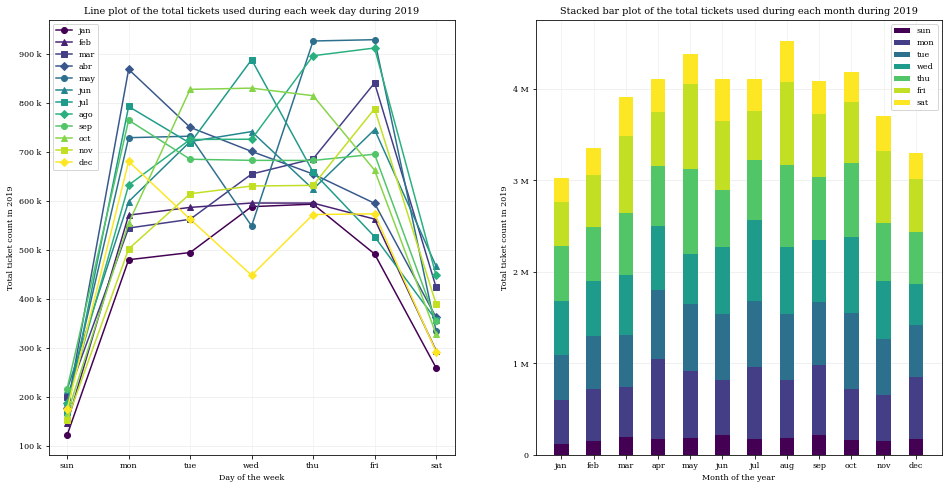

In [62]:
# read outlist from csv
with open("processed-data/numtickets.csv", 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    numtickets = list(csv_reader)

# map to int
acc_month = [int(sub[1]) for sub in numtickets[1:]]
numtickets = [[int(num) for num in sub[2:]] for sub in numtickets[1:]]

# plot config: two plots side by side
font = {'family': 'serif',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# colormap
color_map = cm.get_cmap('viridis', 12)

# plot 1) line plot
axs[0].grid(axis='x', which='both', color='0.95')
axs[0].grid(axis='y', which='major', color='0.93')
axs[0].grid(axis='y', which='minor', color='0.96')

# use k for thousends in y axis
axs[0].yaxis.set_major_formatter(ticker.EngFormatter())

axs[0].set_title("Line plot of the total tickets used during each week day during 2019")
axs[0].set_xlabel("Day of the week")
axs[0].set_ylabel("Total ticket count in 2019")
axs[0].xaxis.set_ticks([0,1,2,3,4,5,6,7])
axs[0].set_xticklabels(['','sun','mon','tue','wed','thu','fri','sat'])

# plot data from 12 months
axs[0].plot(range(1,8), numtickets[0], marker='o', color=color_map(0), label='jan')
axs[0].plot(range(1,8), numtickets[1], marker='^', color=color_map(1), label='feb')
axs[0].plot(range(1,8), numtickets[2], marker='s', color=color_map(2), label='mar')
axs[0].plot(range(1,8), numtickets[3], marker='D', color=color_map(3), label='abr')
axs[0].plot(range(1,8), numtickets[4], marker='o', color=color_map(4), label='may')
axs[0].plot(range(1,8), numtickets[5], marker='^', color=color_map(5), label='jun')
axs[0].plot(range(1,8), numtickets[6], marker='s', color=color_map(6), label='jul')
axs[0].plot(range(1,8), numtickets[7], marker='D', color=color_map(7), label='ago')
axs[0].plot(range(1,8), numtickets[8], marker='o', color=color_map(8), label='sep')
axs[0].plot(range(1,8), numtickets[9], marker='^', color=color_map(9), label='oct')
axs[0].plot(range(1,8), numtickets[10], marker='s', color=color_map(10), label='nov')
axs[0].plot(range(1,8), numtickets[11], marker='D', color=color_map(11), label='dec')

axs[0].legend()

# plot 2) stacked bar plot
axs[1].grid(axis='x', which='both', color='0.95')
axs[1].grid(axis='y', which='major', color='0.93')
axs[1].grid(axis='y', which='minor', color='0.96')

# use M for millions in y axis
axs[1].yaxis.set_major_formatter(ticker.EngFormatter())

axs[1].set_title("Stacked bar plot of the total tickets used during each month during 2019")
axs[1].set_xlabel("Month of the year")
axs[1].set_ylabel("Total ticket count in 2019")
axs[1].xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1].set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

# plot data from 12 months 
width = 0.45 
axs[1].bar(range(1,13), [item[0] for item in numtickets], width, color=color_map(0), zorder=10, label='sun')
bottom = [item[0] for item in numtickets]
axs[1].bar(range(1,13), [item[1] for item in numtickets], width, color=color_map(2), zorder=10, label='mon', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[1] for item in numtickets])]
axs[1].bar(range(1,13), [item[2] for item in numtickets], width, color=color_map(4), zorder=10, label='tue', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[2] for item in numtickets])]
axs[1].bar(range(1,13), [item[3] for item in numtickets], width, color=color_map(6), zorder=10, label='wed', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[3] for item in numtickets])]
axs[1].bar(range(1,13), [item[4] for item in numtickets], width, color=color_map(8), zorder=10, label='thu', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[4] for item in numtickets])]
axs[1].bar(range(1,13), [item[5] for item in numtickets], width, color=color_map(10), zorder=10, label='fri', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[5] for item in numtickets])]
axs[1].bar(range(1,13), [item[6] for item in numtickets], width, color=color_map(12), zorder=10, label='sat', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[6] for item in numtickets])]

axs[1].legend()

plt.tight_layout()

# save figure
plt.savefig("processed-data/numtickets.png", format='png', facecolor="w")
plt.savefig("processed-data/numtickets.pdf", format='pdf', facecolor="w")

#### Hallazgos
* Generalidades
  * El total de boletos en el 2019 es de 46810109 (46.8 millones de boletos)
* Estacionalidad Diaria
  * Días laborales: 16.5% (Lun), 17.1% (Mar), 17.0% (Mie), 17.7% (Jue) y 17.9% (Vie)
  * Días no laborales: 9.2% (Sab) y 4.5% (Dom) 
  * Mínimos: Dom, Lun, Mar, Mie, Vie y Sab en Enero, Jue en Diciembre
  * Máximos: Dom Sept, Lun Abril, Mar Oct, Mie Jul, Jue May, Vie May, y Sab Jun
* Estacionalidad Mensual
  * Menor participación en el proporcional de corte de boletos: Enero con 6.5%
  * Mayor participación en el proporcional de corte de boletos: Agosto con 9.7%(seguido por Mayo con un 9.4% del total anual)


### Análisis Tarjetas por Fechas

#### Datecards
En base a los datos de boletos acumulados obtenidos en `datescards.csv` realizamos un grafico con las N=12 tarjetas más utilizadas de la base de datos, y con las N=12 tarjetas en la media de la utilización.

In [7]:
# running this function can take 3 minutes or more
load_datescards()

loading datecards csv...
converting format...
sorting...
done!


In [8]:
# total cards registered in the year
len(datescards)

0

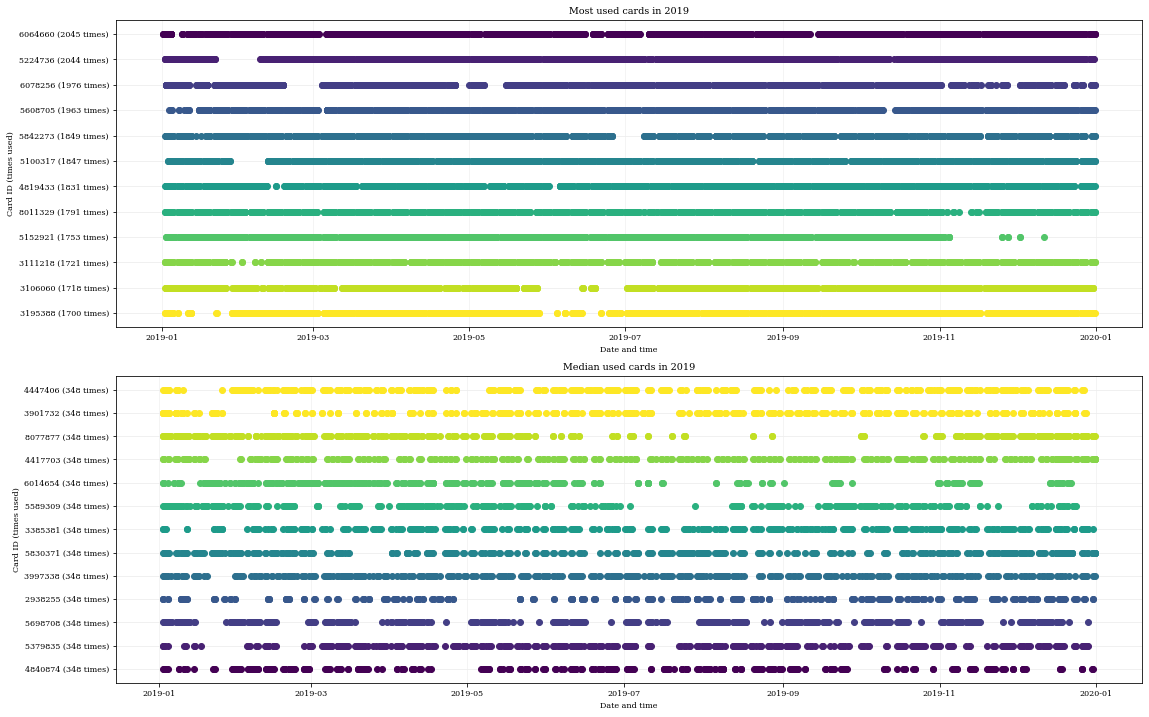

In [5]:
# plot config: two plots side by side
font = {'family': 'serif',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

# colormap
color_map = cm.get_cmap('viridis', 12)

# plot 1) N most used cards
axs[0].grid(axis='x', which='both', color='0.95')
axs[0].grid(axis='y', which='major', color='0.93')
axs[0].grid(axis='y', which='minor', color='0.96')

axs[0].set_title("Most used cards in 2019")
axs[0].set_xlabel("Date and time")
axs[0].set_ylabel("Card ID (times used)")

# plot N most used cards
for n in reversed(range(12)):
    axs[0].scatter(datescards[n][1:], [item for item in [str(datescards[n][0]) + ' ({} times)'.format(len(datescards[n][1:]))] for i in range(len(datescards[n][1:]))],  color=color_map(n), zorder=10)

# plot 2) N least used cards
axs[1].grid(axis='x', which='both', color='0.95')
axs[1].grid(axis='y', which='major', color='0.93')
axs[1].grid(axis='y', which='minor', color='0.96')

axs[1].set_title("Median used cards in 2019")
axs[1].set_xlabel("Date and time")
axs[1].set_ylabel("Card ID (times used)")

# plot n median used cards
median = round(len(datescards)/2)
for n in range(median - 6, median + 7):
    axs[1].scatter(datescards[-n][1:], [item for item in [str(datescards[-n][0]) + ' ({} times)'.format(len(datescards[-n][1:]))] for i in range(len(datescards[-n][1:]))],  color=color_map(n + 6 - median), zorder=10)

plt.tight_layout()

# save figure
plt.savefig("processed-data/datescards.png", format='png', facecolor="w")
plt.savefig("processed-data/datescards.pdf", format='pdf', facecolor="w")
    

#### Deltas
En base a los datos de los delta de tiempos guardados en `deltas.csv` y `carddeltas.csv` realizamos un grafico con un histograma de los delta de tiempos y una lista con las 20 tarjetas con más usos compartidos.

In [ ]:
# running this function can take 3 minutes or more
load_deltas()

In [46]:
len(carddeltas)

117793

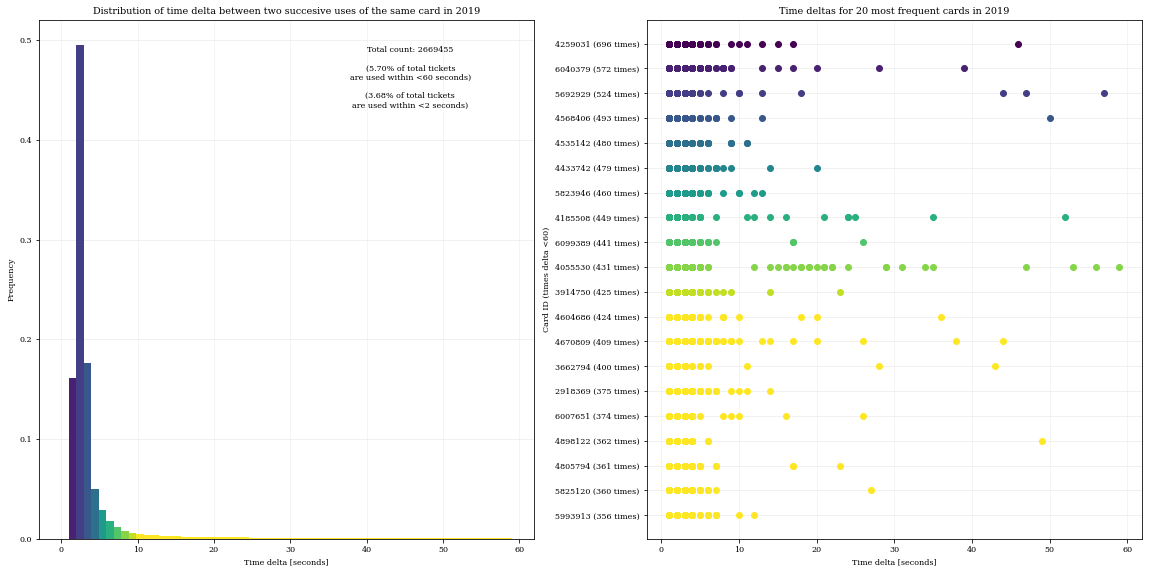

In [44]:
# plot config: two plots side by side
font = {'family': 'serif',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# colormap
color_map = cm.get_cmap('viridis', 12)

# plot 1) max_delta = 60
axs[0].grid(axis='x', which='both', color='0.95')
axs[0].grid(axis='y', which='major', color='0.93')
axs[0].grid(axis='y', which='minor', color='0.96')

axs[0].set_title("Distribution of time delta between two succesive uses of the same card in 2019")
axs[0].set_xlabel("Time delta [seconds]")
axs[0].set_ylabel("Frequency")

num_bins = 60
n, bins, patches = axs[0].hist(deltas, num_bins, density=True, zorder=10)

# colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col) / 6
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))

# text annotation
text = "Total count: {}\n\n".format(len(deltas))
text += "({:.2f}% of total tickets\n".format(100*len(deltas)/46810109)
text += "are used within <60 seconds)\n\n"
text += "({:.2f}% of total tickets\n".format(100*len([x for x in deltas if x <= 2])/46810109)
text += "are used within <2 seconds)\n\n"
axs[0].text(0.75, 0.95, text, ha='center', va='top', transform=axs[0].transAxes)

# plot 2) Deltas for 20 most frequent cards
axs[1].grid(axis='x', which='both', color='0.95')
axs[1].grid(axis='y', which='major', color='0.93')
axs[1].grid(axis='y', which='minor', color='0.96')

axs[1].set_title("Time deltas for 20 most frequent cards in 2019")
axs[1].set_xlabel("Time delta [seconds]")
axs[1].set_ylabel("Card ID (times delta <60)")

for n in reversed(range(20)):
    axs[1].scatter(carddeltas[n][1:], [item for item in [str(carddeltas[n][0]) + ' ({} times)'.format(len(carddeltas[n][1:]))] for i in range(len(carddeltas[n][1:]))],  color=color_map(n), zorder=10)

plt.tight_layout()

# save figure
plt.savefig("processed-data/deltas.png", format='png', facecolor="w")
plt.savefig("processed-data/deltas.pdf", format='pdf', facecolor="w")

#### Hallazgos
* Generalidades
  * Máximo: la tarjeta más usada registra 1900 boletos en el año
  * Media: la media de la utilización de tarjetas es de 324 boletos
  * Total: el total de tarjetas usadas asciende a 
* Uso compartido
  * Total: el total de boletos compartidos es de 2.6 millones (5.7% del total)
  * Menor a 2 segundos: 3.68% son boletos compartidos dentro los 2 segundos
  * Mayor uso: la tarjeta más compartida se compartió 696 veces

